The main goals of data processing and feature selection include:

- **Deeper Feature Processing**: Implement a reasoned and interpretable approach for advanced feature manipulation.
- **Feature Selection Task**: Determine the most relevant features for inclusion in the model.

Key considerations and steps:

- **Assess Feature Distributions**: Tailor processing methods (especially transformations) to the distinct distributions of various features.
- **Feature Processing Techniques**: Apply suitable transformations to optimize each feature's contribution to the model.
- **Employ WOE & IV for Feature Selection**:
  - Utilize Weights of Evidence (WoE) and Information Value (IV) methods, particularly effective for discrete features in credit risk modeling.
  - For continuous features, implement binning to discretize the data, facilitating the application of WoE and IV analysis.

This streamlined approach ensures a focused and effective feature selection process, enhancing model performance and interpretability.

### Load Data

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import os

import warnings
warnings.filterwarnings('ignore')

Based on the EDA and normality tests conducted on continuous data, only two features were found to conform to a normal distribution: `annual_inc` and `tot_cur_bal`. However, upon visual examination through histogram plots, it was observed that while `annual_inc` closely follows a normal distribution, `tot_cur_bal` does not, exhibiting a left-skewed distribution instead.

Therefore, the approach to data transformation for these features is as follows:

- **`annual_inc`**: Given its alignment with a normal distribution, z-score normalization is appropriate for this feature to standardize its values.

- **`tot_cur_bal`**: Due to its left-skewed distribution, a log transformation is considered to address the skewness. Although the RobustScaler from scikit-learn is also capable of handling outliers effectively, the dataset was found to have minimal outliers, making log transformation the preferred choice.

For further details on scaling and transformations, refer to the scikit-learn documentation on preprocessing and scaling: [Scaling with scikit-learn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html).

The remaining data will be subject to feature selection processes to determine the most impactful features for subsequent modeling efforts.

In [7]:
path = os.getcwd()
# get the data from the 1-data_cleaning folder for two csv files, us os.path.join

discrete_file_path = os.path.join(path, 'data', '1-data_cleaning', 'df_discrete_features.csv')
continuous_file_path = os.path.join(path, 'data', '1-data_cleaning', 'df_continuous_features.csv')

# read the csv files
df_discrete = pd.read_csv(discrete_file_path, index_col=0)
df_continuous = pd.read_csv(continuous_file_path, index_col=0)

# 1. Continuous data    

In [8]:
# for all continuous features, the EDA shows that all of them are skewed, so I would like to take 95% to 99% quantile to remove outliers

def return_with_9x_quantile_df(df, quantile_value = 0.95):
    df_9x_quantile = pd.DataFrame()
    for col in df.columns:
        df_9x_quantile[col] = df[col][df[col] <= df[col].quantile(quantile_value)]
    removed_rows = df.shape[0] - df_9x_quantile.shape[0]
    print("Return a dataframe with {} quantile for all continuous features.".format(int(quantile_value*100)))
    print("Remove {} rows.".format(removed_rows))
    
    return df_9x_quantile

In [9]:
df_continuous_9x_quantile = return_with_9x_quantile_df(df_continuous, quantile_value = 0.95)

Return a dataframe with 95 quantile for all continuous features.
Remove 23292 rows.


array([[<Axes: title={'center': 'installment'}>,
        <Axes: title={'center': 'annual_inc'}>,
        <Axes: title={'center': 'revol_bal'}>],
       [<Axes: title={'center': 'out_prncp'}>,
        <Axes: title={'center': 'out_prncp_inv'}>,
        <Axes: title={'center': 'total_pymnt'}>],
       [<Axes: title={'center': 'total_pymnt_inv'}>,
        <Axes: title={'center': 'total_rec_prncp'}>,
        <Axes: title={'center': 'total_rec_int'}>],
       [<Axes: title={'center': 'last_pymnt_amnt'}>,
        <Axes: title={'center': 'tot_cur_bal'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

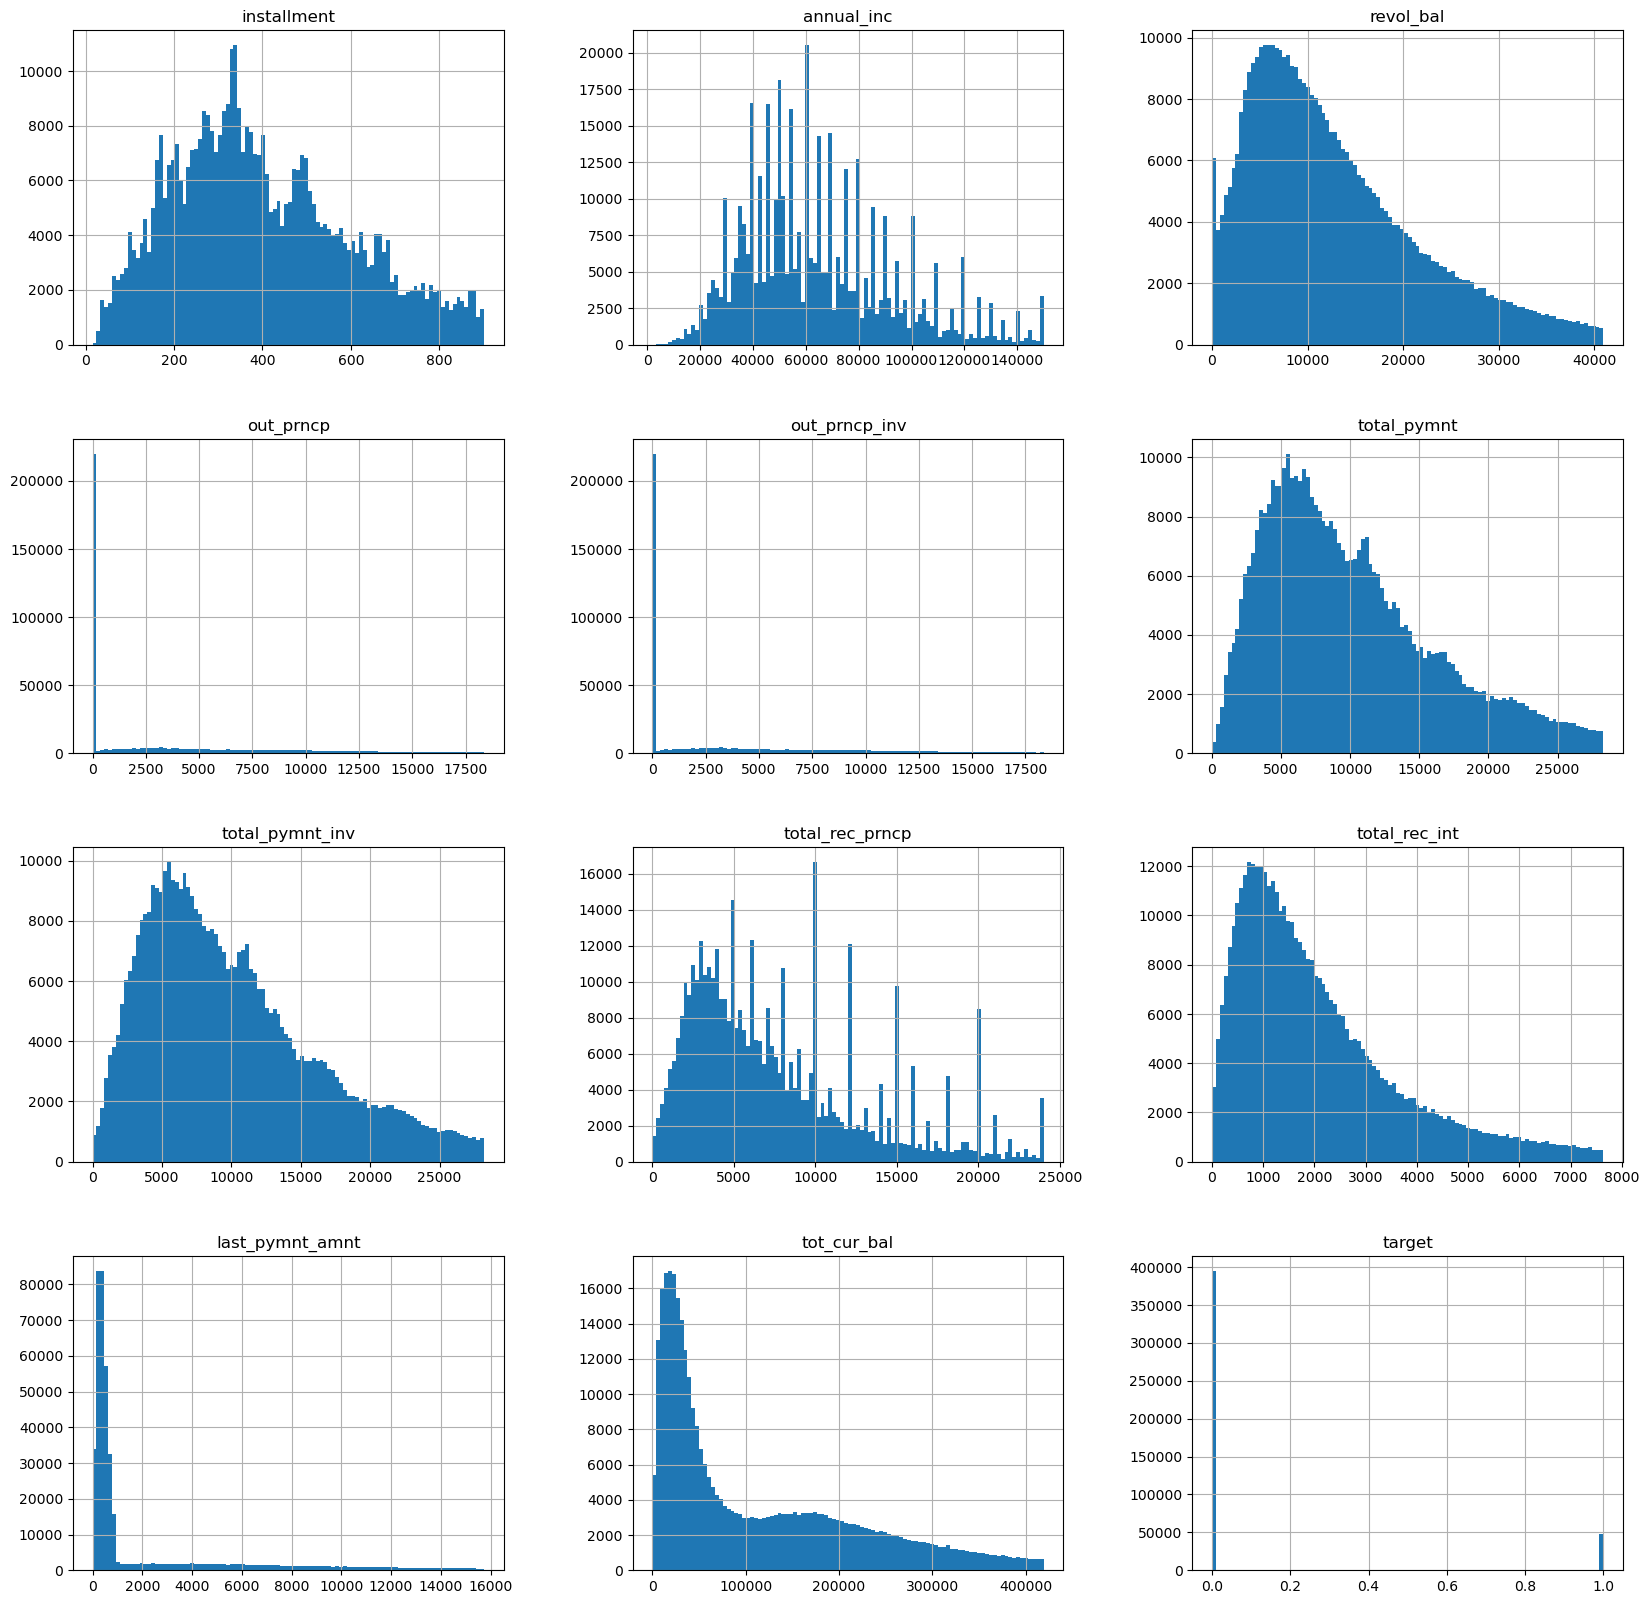

In [10]:
df_continuous_9x_quantile[:-1].hist(figsize=(20,20), bins=100)

In [11]:
# for the convenience of the following processing, I would like to take the features with a clear distribution, 
#   which means the features with a skewness with the range of 0.5 to -0.5
def return_skewness_df(df, skewness_upper_range = 0.5, skewness_lower_range = -0.5):
    skewness = df[:-1].skew(axis=0)
    skewness_df = skewness[(skewness > skewness_lower_range) & (skewness < skewness_upper_range)]
    print("Return a dataframe with skewness between {} and {}.".format(skewness_lower_range, skewness_upper_range))
    return skewness_df

In [12]:
# since all the skewness are positive, I would like to take the skewness between 0 and 1
df_continuous_9x_quantile_skewness = return_skewness_df(df_continuous_9x_quantile, skewness_upper_range = 1, skewness_lower_range = 0)

Return a dataframe with skewness between 0 and 1.


In [13]:
df_continuous_9x_quantile_skewness

installment        0.477559
annual_inc         0.767491
revol_bal          0.918644
total_pymnt        0.817331
total_pymnt_inv    0.813015
total_rec_prncp    0.983972
tot_cur_bal        0.971103
dtype: float64

To address the right skewness in my dataset, I've considered three transformation methods: 
- square root 
- cube root
- logarithmic transformations

For consistency and effectiveness in the subsequent steps, I plan to primarily utilize the logarithmic transformation. This decision is based on its proven ability to normalize right-skewed data effectively.

Regarding the specific features in focus:

- **For `annual_inc`**:
  - I've observed that it closely approximates a Gaussian distribution. Therefore, I have two options: applying a logarithmic transformation to mitigate any remaining skewness or employing z-score normalization to standardize the distribution.

- **For `tot_cur_bal`**:
  - This feature does not exhibit a Gaussian-like distribution and is significantly right-skewed. To address this, I'm considering either a logarithmic transformation to correct the skewness or the use of a RobustScaler, which is particularly effective in handling outliers.

My strategy for transforming the data involves applying different methods to various features, depending on their distribution characteristics, to enhance their utility in modeling:

- **Log Transformation Only**:
  - I plan to apply log transformation to features such as `installment`, `revol_bal`, `total_pymnt`, `total_pymnt_inv`, and `total_rec_prncp`. This method is suitable given their right-skewed distributions, aiming to make these distributions more symmetric.

- **Z-Score Transformation and Log Transformation**:
  - For `annual_inc`, I am considering both z-score normalization and log transformation. The former will standardize the feature, aligning it with the assumptions of normality required by many models, while the latter could further refine its distribution towards Gaussian characteristics.

- **Log Transformation and Robust Scaler Transformation**:
  - For `tot_cur_bal`, I am evaluating the use of log transformation to address its skewness and considering the RobustScaler as an alternative to diminish the impact of outliers. My choice between these methods will be informed by the extent of skewness and the presence of outliers within this feature.

This approach ensures that each feature is processed in a way that maximizes its compatibility with statistical modeling techniques, potentially enhancing the interpretability and effectiveness of the predictive models I aim to build.

In [14]:
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np

def transform_features(df, log_features=[], z_score_features=[], robust_features=[], target_feature='target'):
    """
    Apply specified transformations to the given features of the DataFrame and return a DataFrame with
    only the transformed features and the target variable.

    Parameters:
    - df: pandas DataFrame, the original DataFrame.
    - log_features: list of strings, names of features to apply log transformation.
    - z_score_features: list of strings, names of features to apply z-score normalization.
    - robust_features: list of strings, names of features to apply robust scaling.
    - target_feature: string, the name of the target variable.

    Returns:
    - df_selected: pandas DataFrame, the DataFrame with only transformed features and the target variable.
    """
    df_transformed = df.copy()

    # Log transformation
    for feature in log_features:
        df_transformed[feature] = np.log1p(df_transformed[feature])

    # Z-score normalization
    for feature in z_score_features:
        scaler = StandardScaler()
        transformed_feature = scaler.fit_transform(df_transformed[feature].values.reshape(-1, 1)).flatten()
        df_transformed[feature] = transformed_feature

    # Robust scaling
    for feature in robust_features:
        scaler = RobustScaler()
        transformed_feature = scaler.fit_transform(df_transformed[feature].values.reshape(-1, 1)).flatten()
        df_transformed[feature] = transformed_feature

    # Select only the transformed features and the target variable
    transformed_features = log_features + z_score_features + robust_features
    df_selected = df_transformed[transformed_features + [target_feature]]

    return df_selected


In [15]:
log_features = ['installment', 'revol_bal', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp']
z_score_features = ['annual_inc']
robust_features = ['tot_cur_bal']
transformed_df = transform_features(df_continuous_9x_quantile, log_features, z_score_features, robust_features)
transformed_df.head()

,installment,revol_bal,total_pymnt,total_pymnt_inv,total_rec_prncp,annual_inc,tot_cur_bal,target
0,5.099073,9.521422,8.676258,8.671249,8.517393,-1.439356,NaN,0
1,4.108083,7.431300,6.917418,6.917418,6.125689,-1.227798,NaN,1
2,4.446526,7.991931,8.007918,8.007916,7.783641,-1.853586,NaN,0
3,5.829857,8.630343,9.411427,9.411426,9.210440,-0.550813,NaN,0
4,4.231058,10.232216,8.084307,8.084307,7.711594,0.535184,NaN,0


# 2.WOE & IV

## 2.1 WOE & IV for Discrete Features

https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In the context of feature selection for discrete features, the use of Weight of Evidence (WOE) and Information Value (IV) stands out as an effective approach. These statistical methods, rooted in logistic regression, are invaluable in predictive modeling, particularly in scenarios like credit scoring. WOE offers a measure of the predictive strength of individual categories within a feature by comparing the likelihood of positive outcomes to negative ones, while IV assesses the overall predictive capability of a feature, with higher IV values indicating stronger predictive power.

In [16]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
            val = list(dataset[feature].unique())[i]
            lst.append({
                'Value': val,
                'All': dataset[dataset[feature] == val].count()[feature],
                'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
                'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
            })
            
    dset = pd.DataFrame(lst)
    dset['Good_ratio'] = dset['Good'] / dset['Good'].sum()
    dset['Bad_ratio'] = dset['Bad'] / dset['Bad'].sum()
    
    dset['WoE'] = np.log(dset['Good_ratio'] / dset['Bad_ratio'])
    
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Good_ratio'] - dset['Bad_ratio']) * dset['WoE']
    iv = dset['IV'].sum()

    dset = dset.sort_values(by='WoE')

    return dset, iv


def get_woe_iv_discrete_df(df_discrete, discrete_df_columns, target='target'):
    df_woe_iv = []
    iv_df = {}
    for col in discrete_df_columns:
        if col == 'target': continue
        else:
            print('WoE and IV for column: {}'.format(col))
            df_w_v, iv = calculate_woe_iv(df_discrete, col, target)
            df_woe_iv.append(df_w_v)
            iv_df[col] = iv

    discrete_woe_iv  = pd.DataFrame(columns=['Value', 'All', 'Good', 'Bad', 'Good_ratio', 'Bad_ratio', 'WoE', 'IV'])

    for i in range(len(df_woe_iv)):
        # use condiscrete to combine the dataframes
        discrete_woe_iv = pd.concat([discrete_woe_iv, df_woe_iv[i]], axis=0)

    # iv_df dict into data frame
    discrete_iv = pd.DataFrame.from_dict(iv_df, orient='index')
    # sort the dataframe by iv
    discrete_iv = discrete_iv.sort_values(by=0, ascending=False)
    print("Done")
    return discrete_iv, discrete_woe_iv, 

In [17]:
discrete_iv, discrete_woe_iv,  = get_woe_iv_discrete_df(df_discrete, df_discrete.columns, 'target')

WoE and IV for column: loan_amnt
WoE and IV for column: funded_amnt
WoE and IV for column: funded_amnt_inv
WoE and IV for column: term
WoE and IV for column: int_rate
WoE and IV for column: grade
WoE and IV for column: sub_grade
WoE and IV for column: emp_length
WoE and IV for column: home_ownership
WoE and IV for column: verification_status
WoE and IV for column: pymnt_plan
WoE and IV for column: purpose
WoE and IV for column: addr_state
WoE and IV for column: dti
WoE and IV for column: delinq_2yrs
WoE and IV for column: earliest_cr_line
WoE and IV for column: inq_last_6mths
WoE and IV for column: open_acc
WoE and IV for column: pub_rec
WoE and IV for column: revol_util
WoE and IV for column: total_acc
WoE and IV for column: initial_list_status
WoE and IV for column: total_rec_late_fee
WoE and IV for column: recoveries
WoE and IV for column: collection_recovery_fee
WoE and IV for column: last_pymnt_d
WoE and IV for column: last_credit_pull_d
WoE and IV for column: collections_12_mths_

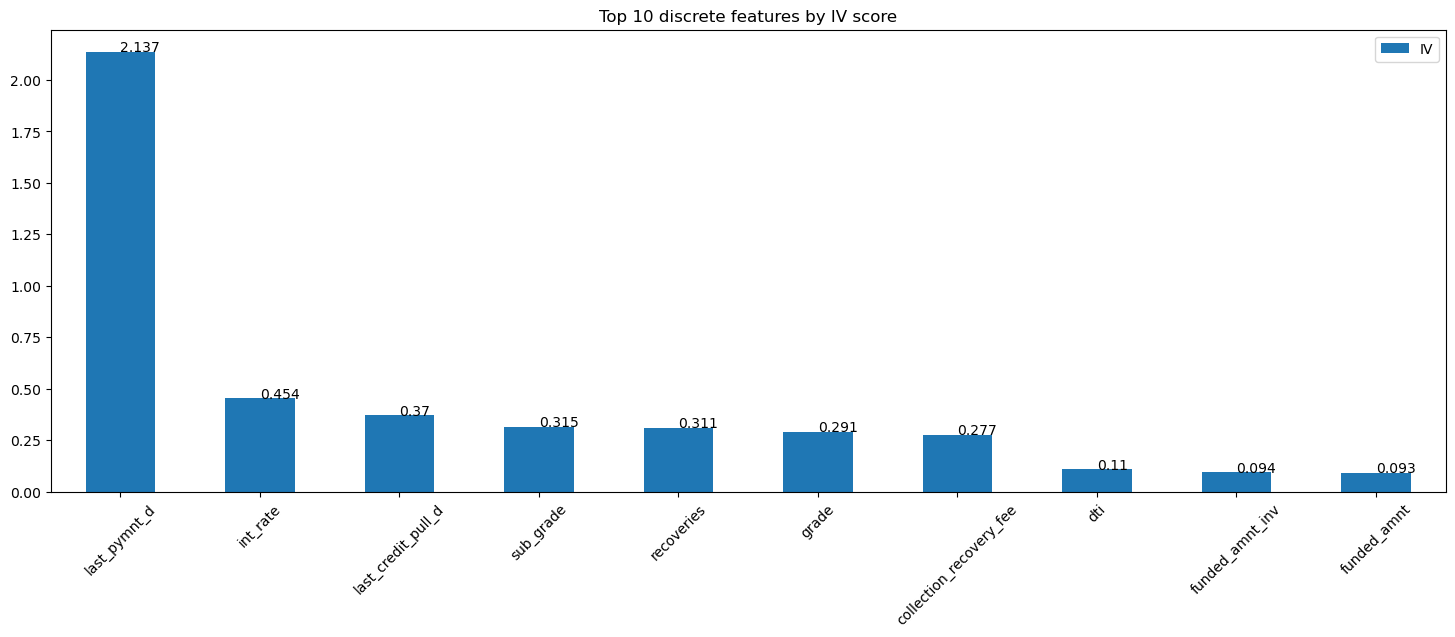

In [24]:
discrete_iv.rename(columns={0: 'IV'}, inplace=True)
discrete_iv = discrete_iv.sort_values(by='IV', ascending=False)
# largest order at the top on the plot
discrete_iv[:10].plot.bar(figsize=(18,6))
for i in range(10):
    plt.text(i, discrete_iv['IV'][i], round(discrete_iv['IV'][i], 3))
plt.xticks(rotation=45)
plt.title('Top 10 discrete features by IV score')
plt.show()

In [25]:
# select the features with IV score larger than 0.3
discrete_feature_IV_over_03 = discrete_iv[discrete_iv['IV'] >= 0.3].index.tolist()
discrete_feature_IV_over_03

['last_pymnt_d', 'int_rate', 'last_credit_pull_d', 'sub_grade', 'recoveries']

## 2.2 WOE & IV for Continuous Features

For continuous features in my dataset, I plan to employ a binning strategy as a preliminary step before applying Weight of Evidence (WoE) and Information Value (IV) analysis. This approach is instrumental in transforming these continuous variables into categorical ones, enabling the use of WoE and IV, which are particularly powerful in predictive modeling contexts such as credit scoring.

Binning Process:
I'll segment the range of each continuous feature into discrete intervals. This can be achieved through various binning techniques, such as equal-width binning, quantile-based binning, or custom binning based on domain knowledge.
Post-binning, each continuous feature will be represented as a series of categories, each corresponding to a specific range of values.

In [26]:
import pandas as pd
import numpy as np

def iv_woe(data, target, bins=10, show_woe=False):
    """
    Calculate Weight of Evidence (WoE) and Information Value (IV) for features in a dataset.

    Parameters:
    - data (pd.DataFrame): The dataset containing features and a binary target variable.
    - target (str): The column name of the target variable in 'data'.
    - bins (int): The number of bins to use for binning continuous variables. Default is 10.
    - show_woe (bool): If True, displays the WoE table for each feature. Default is False.

    Returns:
    - IV_DF (pd.DataFrame): A DataFrame containing the IV for each feature.
    - WoE_DF (pd.DataFrame): A DataFrame containing detailed WoE calculations for each feature.
    """
    
    # Initialize DataFrames for storing results
    IV_DF, WoE_DF = pd.DataFrame(), pd.DataFrame()

    # Exclude target column and iterate over features
    for feature in data.columns.drop(target):
        print('Processing feature: {}'.format(feature))
        # Check for numeric type and sufficient unique values
        if data[feature].dtype.kind in 'bifc' and len(data[feature].unique()) > bins:
            # Use qcut for binning, handling duplicates by merging
            binned_x = pd.qcut(data[feature], bins, duplicates='drop')
        else:
            # Use original values for non-numeric or discrete features
            binned_x = data[feature]

        # Prepare DataFrame for WoE and IV calculation
        d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        d = d0.groupby('x', as_index=False).agg({'y': ['count', 'sum']})
        d.columns = ['Cutoff', 'N', 'Events']

        # Calculate percentages and WoE values, adjusting to avoid log(0)
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events'] / d['% of Non-Events'])
        d['IV'] = (d['% of Events'] - d['% of Non-Events']) * d['WoE']
        d.insert(0, 'Variable', feature)

        # Update results DataFrames
        IV_DF = pd.concat([IV_DF, pd.DataFrame({'Variable': [feature], 'IV': [d['IV'].sum()]})])
        WoE_DF = pd.concat([WoE_DF, d])

        # Optionally display WoE table
        if show_woe:
            print(d)

    IV_DF.reset_index(drop=True, inplace=True)
    IV_DF = IV_DF.sort_values(by='IV', ascending=False).reset_index(drop=True)
    
    WoE_DF.reset_index(drop=True, inplace=True)
    # Display information value for each feature
    print(IV_DF)

    return IV_DF, WoE_DF

In [27]:
continuous_iv, continuous_woe = iv_woe(df_continuous, 'target', bins=10, show_woe=False)

Processing feature: installment
Processing feature: annual_inc
Processing feature: revol_bal
Processing feature: out_prncp
Processing feature: out_prncp_inv
Processing feature: total_pymnt
Processing feature: total_pymnt_inv
Processing feature: total_rec_prncp
Processing feature: total_rec_int
Processing feature: last_pymnt_amnt
Processing feature: tot_cur_bal
           Variable        IV
0   last_pymnt_amnt  1.465710
1   total_rec_prncp  1.370121
2         out_prncp  0.763507
3     out_prncp_inv  0.763473
4   total_pymnt_inv  0.615404
5       total_pymnt  0.609563
6        annual_inc  0.054247
7       tot_cur_bal  0.034726
8     total_rec_int  0.023422
9         revol_bal  0.005749
10      installment  0.004546


In [28]:
# here we will select the features with IV > 0.5
continue_feature_IV_over_05 = continuous_iv[continuous_iv['IV'] > 0.5]['Variable'].tolist()
continue_feature_IV_over_05

['last_pymnt_amnt',
 'total_rec_prncp',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_pymnt']

## 2.3 Save the selected features

In [31]:
discrete_feature_IV_over_03 = discrete_feature_IV_over_03 + ['target']
continue_feature_IV_over_05 = continue_feature_IV_over_05 + ['target']

In [32]:
# save the selected features into a csv file from both discrete and continuous features
df_selected_features = pd.DataFrame()
# get the selected features from discrete features from discrete_feature_IV_over_03
for col in discrete_feature_IV_over_03:
    df_selected_features[col] = df_discrete[col]
# get the selected features from continuous features from continue_feature_IV_over_05
for col in continue_feature_IV_over_05:
    df_selected_features[col] = df_continuous[col]
df_selected_features.head()

,last_pymnt_d,int_rate,last_credit_pull_d,sub_grade,recoveries,target,last_pymnt_amnt,total_rec_prncp,out_prncp,out_prncp_inv,total_pymnt_inv,total_pymnt
0,Jan-15,10.65,Jan-16,B2,0.00,0,171.62,5000.00,0.0,0.0,5831.78,5861.071414
1,Apr-13,15.27,Sep-13,C4,117.08,1,119.66,456.46,0.0,0.0,1008.71,1008.710000
2,Jun-14,15.96,Jan-16,C5,0.00,0,649.91,2400.00,0.0,0.0,3003.65,3003.653644
3,Jan-15,13.49,Jan-15,C1,0.00,0,357.48,10000.00,0.0,0.0,12226.30,12226.302210
4,Jan-16,12.69,Jan-16,B5,0.00,0,67.79,2233.10,766.9,766.9,3242.17,3242.170000


In [33]:
# drop na and reset index
df_selected_features = df_selected_features.dropna().reset_index(drop=True)
# replace the target value to the end of the dataframe
df_selected_features = df_selected_features[[col for col in df_selected_features.columns if col != 'target'] + ['target']]
df_selected_features.head()

,last_pymnt_d,int_rate,last_credit_pull_d,sub_grade,recoveries,last_pymnt_amnt,total_rec_prncp,out_prncp,out_prncp_inv,total_pymnt_inv,total_pymnt,target
0,Jan-15,10.65,Jan-16,B2,0.00,171.62,5000.00,0.0,0.0,5831.78,5861.071414,0
1,Apr-13,15.27,Sep-13,C4,117.08,119.66,456.46,0.0,0.0,1008.71,1008.710000,1
2,Jun-14,15.96,Jan-16,C5,0.00,649.91,2400.00,0.0,0.0,3003.65,3003.653644,0
3,Jan-15,13.49,Jan-15,C1,0.00,357.48,10000.00,0.0,0.0,12226.30,12226.302210,0
4,Jan-16,12.69,Jan-16,B5,0.00,67.79,2233.10,766.9,766.9,3242.17,3242.170000,0


In [34]:
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465867 entries, 0 to 465866
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   last_pymnt_d        465867 non-null  object 
 1   int_rate            465867 non-null  float64
 2   last_credit_pull_d  465867 non-null  object 
 3   sub_grade           465867 non-null  object 
 4   recoveries          465867 non-null  float64
 5   last_pymnt_amnt     465867 non-null  float64
 6   total_rec_prncp     465867 non-null  float64
 7   out_prncp           465867 non-null  float64
 8   out_prncp_inv       465867 non-null  float64
 9   total_pymnt_inv     465867 non-null  float64
 10  total_pymnt         465867 non-null  float64
 11  target              465867 non-null  int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 42.7+ MB


In [36]:
# create a folder to save the selected features
# check the folder in the path, if not exist, create one

if not os.path.exists(os.path.join(path, 'data', '3-data_processing_feature_selection')):
    os.makedirs(os.path.join(path, 'data', '3-data_processing_feature_selection'))
df_selected_features.to_csv(os.path.join(path, 'data', '3-data_processing_feature_selection', 'df_selected_features.csv'))